In [1]:
import os
os.chdir("../../")

In [2]:
import flax
from flax import linen as nn
from flax.core import unfreeze

import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import seaborn as sns

from datasets import sin_data
import tensorflow_probability.substrates.jax as tfp

from models.gaussian_mlp import gmlp 
from models.mlp import mlp 
from utilities.fits import fit
from utilities.gmm import gmm_mean_var
from utilities.predict import predict

In [3]:
from utilities import plot

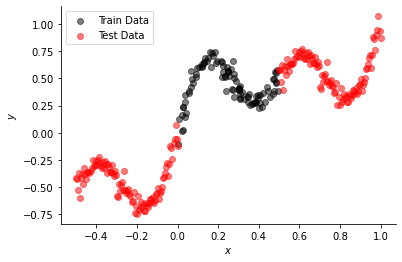

In [4]:
X,y,x_test_1,y_test_1,x_test_2,y_test_2 = sin_data.load_data()
plot.plot_actualdata(X,y,x_test_1,y_test_1,x_test_2,y_test_2)

In [5]:
X_sorted  = jnp.sort(X[:,0]).reshape(100,1)
Y_sorted  = jnp.sort(y)
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,y,y_test_2],axis=0)

## MLP

In [6]:
mlp_model = mlp([32, 32, 1],[nn.relu,nn.relu],[0,0])

In [7]:
mlp_params = mlp_model.init(jax.random.PRNGKey(0), X, True)

In [8]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [9]:
mlp_params, mlp_loss = fit(mlp_model, mlp_params, auxs, learning_rate= 0.01, epochs=2000, verbose=True)

Loss step 0:  0.12494419
Loss step 200:  0.0025141803
Loss step 400:  0.0020413701
Loss step 600:  0.0019541986
Loss step 800:  0.0019801876
Loss step 1000:  0.0019502228
Loss step 1200:  0.0019574196
Loss step 1400:  0.0019441455
Loss step 1600:  0.0019420319
Loss step 1800:  0.0019497558


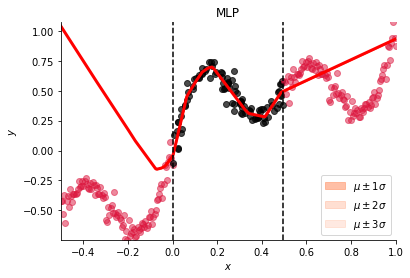

In [10]:
n_points =300
y_hat = mlp_model.apply(mlp_params, x_stack, True)
y_hat = y_hat.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP')

Gaussian MLP

In [11]:
gmlp_model = gmlp(features=[16,16], activations=[nn.relu, nn.relu], dropout_rate=[0.01, 0.01])

In [12]:
gmlp_params = gmlp_model.init(jax.random.PRNGKey(11), X, True)

In [13]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [14]:
gmlp_params, loss = fit(gmlp_model, gmlp_params, auxs,learning_rate=0.003, epochs=2000, verbose=False)

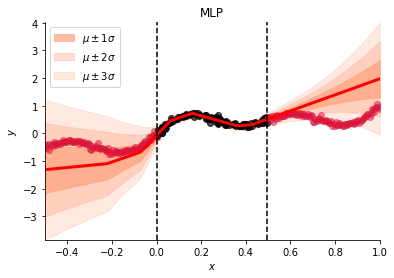

In [15]:
gmlp_mean, gmlp_sigma = gmlp_model.apply(gmlp_params, x_stack, True)
gmlp_mean , gmlp_sigma = gmlp_mean.reshape(n_points), gmlp_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,'MLP')

## MC Dropout Gaussian MLP

In [16]:
n_stacks = 100
fn = lambda i : gmlp_model.apply(gmlp_params, x_stack, deterministic=False, rngs={"dropout": jax.random.PRNGKey(i)})
y_stacks = jax.vmap(fn, in_axes=(0))(jnp.arange(n_stacks))
mean_stacks = y_stacks[0]
sigma_stacks = y_stacks[1]

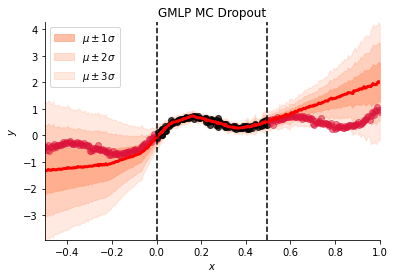

In [17]:
mc_mean, mc_sigma = gmm_mean_var(mean_stacks, sigma_stacks)
mc_mean, mc_sigma= mc_mean.reshape(n_points),mc_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout')

## Deep Ensemble Gaussian MLP

In [18]:
auxs ={
    "X": X,
    "y": y,
    "deterministic" : True
}

In [19]:
params_list = []
losses_list = []
n_models = 5

for i in range(5):
    params = gmlp_model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fit(gmlp_model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)


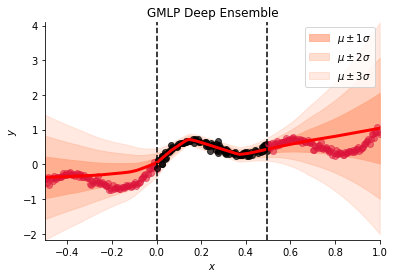

In [20]:
means_list,sigmas_list = predict(n_models, gmlp_model, params_list, x_stack)
de_mean, de_sigma = gmm_mean_var(means_list,sigmas_list)
de_mean, de_sigma = de_mean.reshape(n_points),de_sigma.reshape(n_points)
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble')

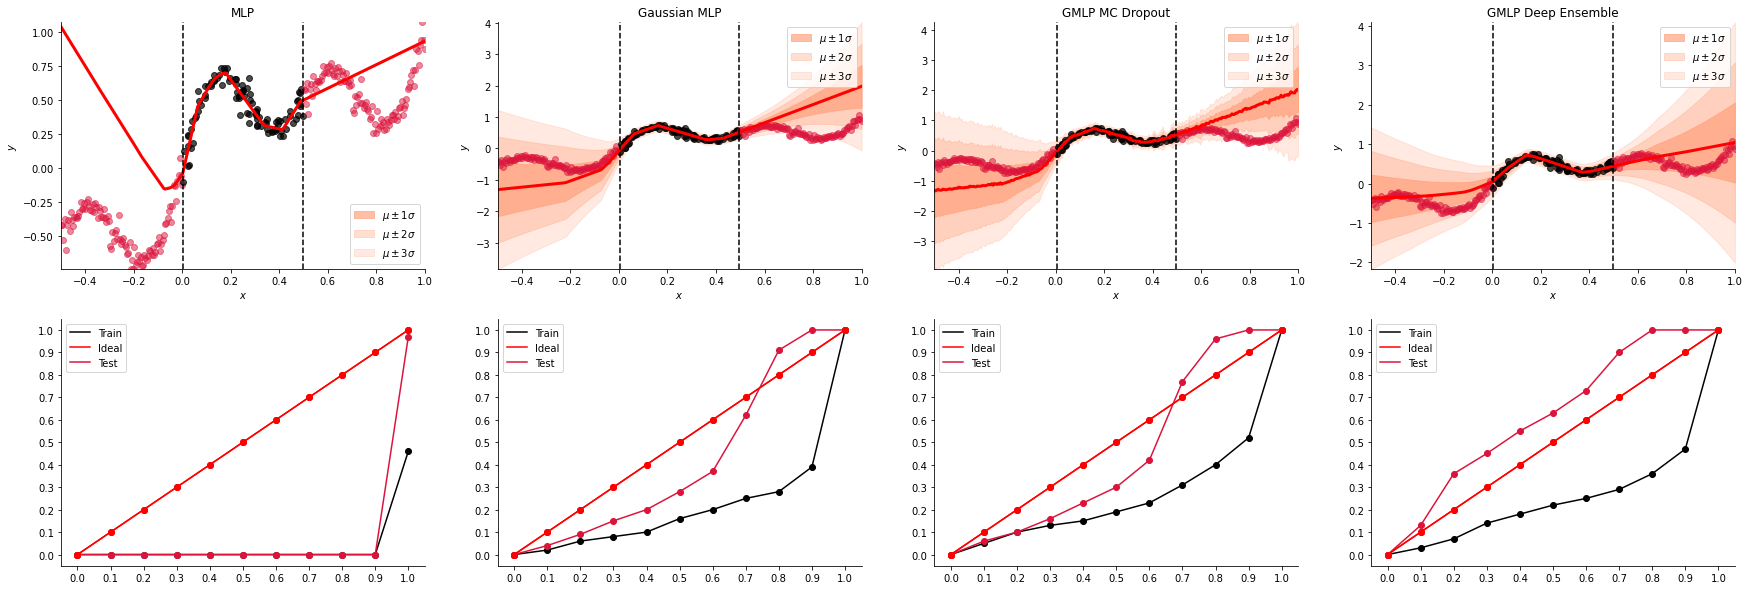

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(30, 10))
plot.plot_prediction(X,y,x_stack,y_stack,y_hat,0,'MLP',ax[0][0])
plot.plot_prediction(X,y,x_stack,y_stack,gmlp_mean,gmlp_sigma,'Gaussian MLP',ax[0][1])
plot.plot_prediction(X,y,x_stack,y_stack,mc_mean,mc_sigma,'GMLP MC Dropout',ax[0][2])
plot.plot_prediction(X,y,x_stack,y_stack,de_mean,de_sigma,'GMLP Deep Ensemble',ax[0][3])
plot.calibration_reg(y_hat,jnp.zeros(300),y_stack,ax[1][0])
plot.calibration_reg(gmlp_mean,gmlp_sigma,y_stack,ax[1][1])
plot.calibration_reg(mc_mean,mc_sigma,y_stack,ax[1][2])
plot.calibration_reg(de_mean,de_sigma,y_stack,ax[1][3])
